## Student ID: 190428550

### Machine Learning and Neural Networks - Template (1)
### Deep Learning on a Public Dataset

##### *This notebook will contain the second iteration of our project, where we will attempt to create an overfitting model and a well performing model by tuning hyperparameters. This is a continuation of the 1st iteration. Any new findings will be reported in new sections.*

[Click Here](#iteration2) to jump to the second iteration section!

### Table of Contents

[Introduction](#introduction) <br>
[Methodology](#methodology) <br>
[Results](#results) <br>
[Evaluation](#conclusion)<br>
[References](#references)

<a id='introduction'></a>
# Introduction

his project aims to create a universal workflow of machine learning using a public dataset obtained from Havard Dataverse. This project references the machine learning workflow found in the book "Deep Learning with Python" by François Chollet. The techniques used in the book will be implemented in this project.

We will attempt to create a model that is statistically powerful enough to predict delays in flights. The flight data only includes domestic flights within United States, so this model may not be suitable to be used for flight delay prediction in international flights. To evaluate whether we have successfully created a statistically powerful model, we will be using the AUC
A problem that we will face using this dataset is that the latest dataset available is only from year 2007, which may not be very indicative of flight delays in the present as factors like improved flight systems and new flight routes may have a significant effect on flight delays now.

<a id='methodology'></a>
# Methodology

### 1. Define the problem and assemble the dataset

The delay of flights will be predicted in this assignment. The data is obtained from Harvard Dataverse and converted into a CSV format for accessibility.

The data contained in this dataset contains columns which are redundant for the exploration of our topic. The columns that will be used as our input to predict flight delays are:

Categorical features:

Month - Month<br>
Day Of Week - Day of Week<br> 
UniqueCarrier - Unique Carrier<br> 
Origin - Origin airport<br> 
Dest - Destination airport<br> 
HourOfDay - Hour(24H format) based on scheduled departure time (CRSDepTime)<br> 

Numerical feature:

Distance - Distance between airports (miles) 

This problem type falls under binary classification as there are only two outputs: Delayed / Not delayed

According to the Bureau of Transportation Statistics, flights that arrive or depart 15 minutes after the scheduled time are considered delayed. Conversely, if a flight arrives or departs within 15 minutes of the scheduled time, it will be considered to be on time.

A target variable column, 'Delayed', will be created which takes integer 1 or 0. Delayed = 1 if ArrDelay exceeds 15 minutes and 0 otherwise.

Problems that may arise given the dataset used:

The dataset only contains the records from the year of 2007. The latest dataset available is from 2008, but only contains the first 4 months of 2008. Hence, the dataset for 2007 was chosen and it is the lastest and most complete.

Although a full range of data is available from 1987 to 2007, only data from the year 2007 will be used for this assigment due to computational limitations. 2007.csv contains more than 7 million rows on its own and takes more than 7 hours to train the model once. Although this is the lastest dataset available, it may not be able to predict current data accurately as the data is more than a decade old. We will be making the assumption that the future will behave like the past.

### 2. Choosing a measure of success

Accuracy metric was initially chosen to gauge our success levels. However, it was found that it does not provide an accurate representation of the model's success. Based on the dataset, an average of 78% of flights are on time and 22% are delayed. Since the data is imbalanced in this case, accuracy cannot be used as the measure of success as it may produce a biassed result.

We will be using ROC AUC and F1 score to gauge the level of success.

### 3. Deciding on an evaluation protocol (Testing)

The model will be evaluated using hold-out validation as we have a large number of data to utilise. The dataset will be split into ‘train’ and ‘test’ sets to evaluate how well the model works on data that has not yet been seen. The training set will be used to train the model. When employing the hold-out method, a typical split is to use 80% of the data for training and the remaining 20% for testing. A confusion matrix will be used to summarise the performance of the classifier.

### 4. Preparing your data

To prepare the data for training, vectorization will be performed on the values in the dataset. The dataset is made up of strings and integers. One-hot encoding must be used on the strings to convert them into a tensor of float32 data for TensorFlow to accept. Furthermore, the data will need to be normalised so that the network can converge. The values will be adjusted by ratio into the range 0-1. The features will also be normalised so that they have a mean of 0 and a standard deviation of 1. The dataset will be examined for invalid or missing values.

In [1]:
# pip install tensorflow
# pip install keras

In [2]:
import pandas as pd
import numpy as np
import os

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers

In [3]:
# read in data from csv, extract 100k samples
# processing data from the other columns

airplane_data = pd.read_csv("2007.csv")
airplane_data = airplane_data.sample(n=100000)

airplane_data['CRSDepTime'].isna().sum() # There are no NA's

airplane_data['CRSDepTime'] = airplane_data['CRSDepTime'].astype(str)
length_of_crsdeptime = airplane_data['CRSDepTime'].str.len()
airplane_data['HourOfDay'] = np.select([length_of_crsdeptime==4, length_of_crsdeptime==3, length_of_crsdeptime<3], [airplane_data['CRSDepTime'].str[0:2], airplane_data['CRSDepTime'].str[0:1], 0], np.nan)
airplane_data['HourOfDay'] = airplane_data['HourOfDay'].astype(int)

In [4]:
# adding a column to determine if flight was delayed based on the arrival delay time

airplane_data = airplane_data.copy()
airplane_data['Delayed'] = np.where(airplane_data['ArrDelay'] > 15, 1, 0) # Creating 'Delayed' column. Delayed = 1 if ArrDelay exceeds 15 minutes, 0 otherwise. 
airplane_data = airplane_data[['Month', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'HourOfDay', 'Delayed']] # Keeping only columns that will be used as features and target variable.

In [5]:
airplane_data.head()

,Month,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,HourOfDay,Delayed
2534355,5,4,WN,MDW,OAK,1844,14,0
4260063,7,3,AA,MCO,SJU,1189,17,1
5957947,10,1,EV,ATL,ROC,749,13,0
870356,2,1,US,BOS,PHL,280,18,1
1271463,3,2,WN,TPA,JAX,180,17,0


In [6]:
# created the features and labels

airplane_features = airplane_data.copy()
airplane_labels = airplane_features.pop('Delayed')

In [7]:
airplane_features.dtypes

Month             int64
DayOfWeek         int64
UniqueCarrier    object
Origin           object
Dest             object
Distance          int64
HourOfDay         int32
dtype: object

In [8]:
# splitting the training and test set into 80:20 ratio

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(airplane_features, airplane_labels, test_size=0.2, random_state=1)

In [9]:
# converting data types for keras

inputs = {}

for name, column in airplane_features.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)
inputs

{'Month': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Month')>,
 'DayOfWeek': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'DayOfWeek')>,
 'UniqueCarrier': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'UniqueCarrier')>,
 'Origin': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Origin')>,
 'Dest': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Dest')>,
 'Distance': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Distance')>,
 'HourOfDay': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'HourOfDay')>}

In [10]:
# normalizing numerical values

numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(airplane_features[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)
all_numeric_inputs

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'normalization')>

In [11]:
preprocessed_inputs = [all_numeric_inputs]

In [12]:
# performing one hot encoding to categorical data

for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue

    lookup = layers.StringLookup(vocabulary=np.unique(airplane_features[name]))
    one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)

In [13]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)
airplane_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

In [14]:
airplane_features_dict = {name: np.array(value) 
                     for name, value in airplane_features.items()}

In [15]:
# feeding all the processed data to the tensor

features_dict = {name:values[:1] for name, values in airplane_features_dict.items()}
airplane_preprocessing(features_dict)

<tf.Tensor: shape=(1, 623), dtype=float32, numpy=
array([[-0.442,  0.034,  1.997,  0.202,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   

In [16]:
# Create function to plot graphs

import matplotlib.pyplot as plt

def plot_loss(loss, val_loss):
    plt.clf()
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_accuracy(acc, val_acc):
    plt.clf()
    epoch = range(1, len(acc) +1)
    plt.plot(epoch, acc, 'bo', label="Training Accuracy")
    plt.plot(epoch, val_acc, 'b', label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

### 5. Developing a model that does better than baseline

The chosen dataset produces two outputs: Delayed / Not delayed.

If we were to perform random guessing on the dataset, we would always have a 50% chance of being correct. Hence, our baseline for the dataset would be 50% accuracy. If our model is able to achieve anything above 50%, it would mean that the model has statistical power at 0.5.

The model falls under binary classification given the two possible outputs. Given the problem type, the last layer activation would make use of sigmoid for the last layer. The loss function that will be applied is binary crossentropy.

In [17]:
# creating AUC metric

tf.keras.metrics.AUC(
    num_thresholds=200,
    curve='ROC',
    summation_method='interpolation',
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False
)

In [18]:
from tensorflow import keras
from keras import optimizers

def airplane_baseline_model(preprocessing_head, inputs):
    body = tf.keras.Sequential([
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])

    preprocessed_inputs = preprocessing_head(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)

    model.compile(optimizer=tf.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC(from_logits=True)])
    return model

airplane_baseline_model = airplane_baseline_model(airplane_preprocessing, inputs)
history_base = airplane_baseline_model.fit(x=airplane_features_dict, 
                                           y=airplane_labels,
                                           epochs=10,
                                           batch_size = 512,
                                           validation_split = 0.2)

Epoch 1/10
157/157 [==============================] - 2s 7ms/step - loss: 0.5481 - accuracy: 0.7619 - auc_1: 0.5766 - val_loss: 0.5209 - val_accuracy: 0.7661 - val_auc_1: 0.6416
Epoch 2/10
157/157 [==============================] - 1s 5ms/step - loss: 0.5160 - accuracy: 0.7679 - auc_1: 0.6514 - val_loss: 0.5181 - val_accuracy: 0.7661 - val_auc_1: 0.6496
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 0.5123 - accuracy: 0.7679 - auc_1: 0.6615 - val_loss: 0.5168 - val_accuracy: 0.7662 - val_auc_1: 0.6531
Epoch 4/10
157/157 [==============================] - 1s 5ms/step - loss: 0.5087 - accuracy: 0.7681 - auc_1: 0.6705 - val_loss: 0.5158 - val_accuracy: 0.7665 - val_auc_1: 0.6547
Epoch 5/10
157/157 [==============================] - 1s 4ms/step - loss: 0.5050 - accuracy: 0.7688 - auc_1: 0.6789 - val_loss: 0.5153 - val_accuracy: 0.7666 - val_auc_1: 0.6571
Epoch 6/10
157/157 [==============================] - 1s 5ms/step - loss: 0.5013 - accuracy: 0.7702 - auc_1: 0

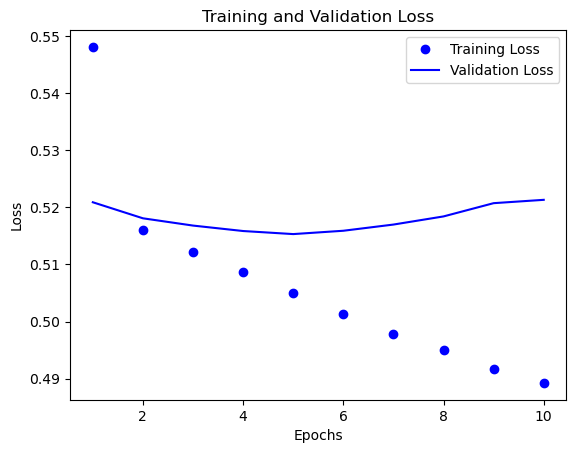

In [19]:
plot_loss(history_base.history['loss'], history_base.history['val_loss'])

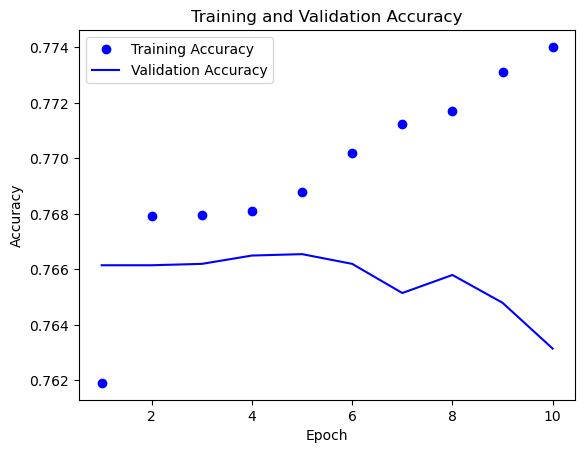

In [20]:
plot_accuracy(history_base.history['accuracy'], history_base.history['val_accuracy'])

In [21]:
airplane_baseline_model.evaluate(x=airplane_features_dict, y=airplane_labels, verbose = 2)

3125/3125 - 6s - loss: 0.4908 - accuracy: 0.7734 - auc_1: 0.7104 - 6s/epoch - 2ms/step


[0.49075937271118164, 0.773419976234436, 0.7104072570800781]

### Loss: 0.50 AUC: 0.68

The AUC obtained a result of 0.68 while the loss function obtained a results of 0.50. The result at this point is acceptable enough to determine that the model has statistical power and can be improved further. The shape of the graph determines that the model is overfitting. In the following weeks, an underfitting model will be created so we can have a rough idea of where a well performing model stands (between the current overfitting and underfitting model).

<a id='iteration2'></a>
## Second Iteration (Overfitting and Well Performing Models)

### 6. Scaling up: developing a model that overfits

Next, we will create an overfitting model. We will increase the complexity of the model by adding layers and increasing the network capacity. We will also increase the number of epochs and adjust the validation test size.

In [22]:
def airplane_overfit_model(preprocessing_head, inputs):
    body = tf.keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])

    preprocessed_inputs = preprocessing_head(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)

    model.compile(loss='binary_crossentropy',
                optimizer=tf.optimizers.Adam(), 
                metrics = ['accuracy', tf.keras.metrics.AUC(from_logits=True)])
    return model

airplane_overfit_model = airplane_overfit_model(airplane_preprocessing, inputs)
history1 = airplane_overfit_model.fit(x=airplane_features_dict, 
                                      y=airplane_labels,
                                      epochs=15,
                                      batch_size = 1024,
                                      validation_split = 0.3)

Epoch 1/15
69/69 [==============================] - 1s 12ms/step - loss: 0.6340 - accuracy: 0.7107 - auc_2: 0.5006 - val_loss: 0.5432 - val_accuracy: 0.7665 - val_auc_2: 0.5775
Epoch 2/15
69/69 [==============================] - 0s 7ms/step - loss: 0.5268 - accuracy: 0.7680 - auc_2: 0.6186 - val_loss: 0.5230 - val_accuracy: 0.7665 - val_auc_2: 0.6359
Epoch 3/15
69/69 [==============================] - 0s 7ms/step - loss: 0.5183 - accuracy: 0.7680 - auc_2: 0.6455 - val_loss: 0.5201 - val_accuracy: 0.7665 - val_auc_2: 0.6431
Epoch 4/15
69/69 [==============================] - 0s 7ms/step - loss: 0.5149 - accuracy: 0.7680 - auc_2: 0.6546 - val_loss: 0.5188 - val_accuracy: 0.7665 - val_auc_2: 0.6466
Epoch 5/15
69/69 [==============================] - 0s 7ms/step - loss: 0.5124 - accuracy: 0.7680 - auc_2: 0.6612 - val_loss: 0.5176 - val_accuracy: 0.7665 - val_auc_2: 0.6492
Epoch 6/15
69/69 [==============================] - 0s 7ms/step - loss: 0.5096 - accuracy: 0.7680 - auc_2: 0.6677 - val

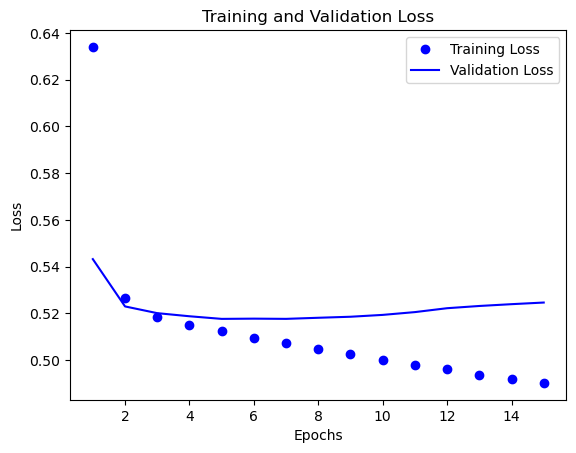

In [23]:
plot_loss(history1.history['loss'], history1.history['val_loss'])

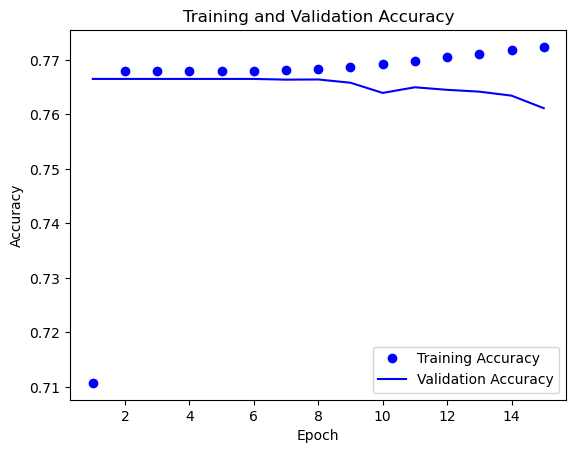

In [24]:
plot_accuracy(history1.history['accuracy'], history1.history['val_accuracy'])

In [25]:
airplane_overfit_model.evaluate(x=airplane_features_dict, y=airplane_labels, verbose = 2)

3125/3125 - 6s - loss: 0.4973 - accuracy: 0.7702 - auc_2: 0.6971 - 6s/epoch - 2ms/step


[0.49734050035476685, 0.7701900005340576, 0.697142481803894]

As expected, the model overfits. When validation AUC decreases, it means a model overfits. We can see that at epoch 10, the validation AUC starts to drop steeply. We will use 10 epochs for our well performing model.

### 7. Regularizing and hypertuning parameters

We will also be adding weight regularisation to mitigate overfitting such as L1/L2 regularisaation or dropout.

In this stage, different architectures will be tested such as adding or removing layers. The hyperparameters will also be adjusted , changing the network size and altering the learning rates.

Developing a <b>well performing</b> model.

We will be adjusting the network complexity by reducing the number of layers, reducing the network size and the number of epochs. We will also add dropout and perform regularization. The learning rate of our optimizer will also be reduced. We will attempt to achieve a high accuracy without overfitting.

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense
from keras import regularizers

def airplane_best_model(preprocessing_head, inputs):
    body = tf.keras.Sequential([
    layers.Dense(16, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu'),
    layers.Dense(8, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='relu'),    
    layers.Dense(1, activation='sigmoid')
    ])

    preprocessed_inputs = preprocessing_head(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)

    model.compile(loss='binary_crossentropy',
                optimizer=tf.optimizers.Adam(),
                metrics = ['accuracy', tf.keras.metrics.AUC(from_logits=True)])
    return model

airplane_model = airplane_best_model(airplane_preprocessing, inputs)
history2 = airplane_model.fit(x=airplane_features_dict, 
                             y=airplane_labels, 
                             epochs=10, 
                             batch_size = 1024,
                             validation_split = 0.3)

Epoch 1/10
69/69 [==============================] - 2s 12ms/step - loss: 0.8788 - accuracy: 0.7631 - auc_3: 0.5402 - val_loss: 0.6351 - val_accuracy: 0.7665 - val_auc_3: 0.6169
Epoch 2/10
69/69 [==============================] - 0s 7ms/step - loss: 0.5985 - accuracy: 0.7680 - auc_3: 0.5840 - val_loss: 0.5695 - val_accuracy: 0.7665 - val_auc_3: 0.6220
Epoch 3/10
69/69 [==============================] - 0s 7ms/step - loss: 0.5732 - accuracy: 0.7680 - auc_3: 0.5903 - val_loss: 0.5599 - val_accuracy: 0.7665 - val_auc_3: 0.6220
Epoch 4/10
69/69 [==============================] - 0s 7ms/step - loss: 0.5639 - accuracy: 0.7680 - auc_3: 0.5911 - val_loss: 0.5530 - val_accuracy: 0.7665 - val_auc_3: 0.6208
Epoch 5/10
69/69 [==============================] - 0s 7ms/step - loss: 0.5567 - accuracy: 0.7680 - auc_3: 0.5928 - val_loss: 0.5480 - val_accuracy: 0.7665 - val_auc_3: 0.6218
Epoch 6/10
69/69 [==============================] - 0s 7ms/step - loss: 0.5511 - accuracy: 0.7680 - auc_3: 0.5949 - val

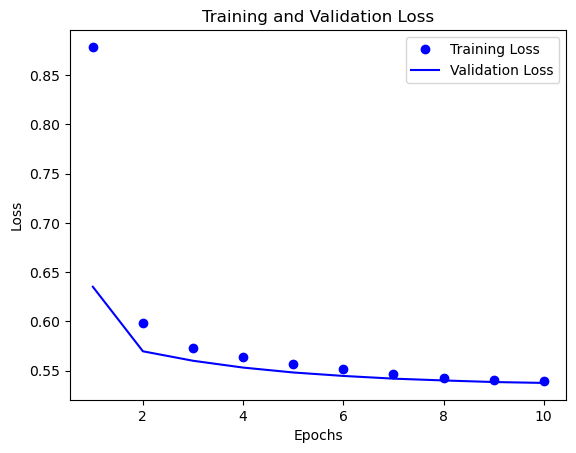

In [27]:
plot_loss(history2.history['loss'], history2.history['val_loss'])

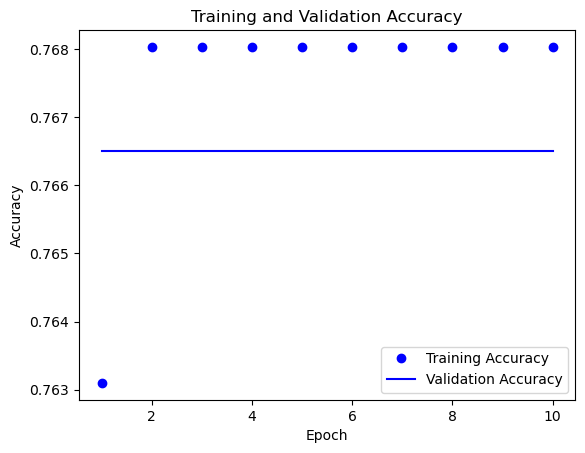

In [28]:
plot_accuracy(history2.history['accuracy'], history2.history['val_accuracy'])

In [29]:
airplane_model.evaluate(x=airplane_features_dict, y=airplane_labels, verbose = 2)

3125/3125 - 6s - loss: 0.5364 - accuracy: 0.7676 - auc_3: 0.6174 - 6s/epoch - 2ms/step


[0.5364256501197815, 0.7675700187683105, 0.6173895597457886]

This well performing model is the best model that we managed to obtain from adjusting the numerous parameters. We managed to obtain a final AUC of 76.7%, which is still statistically powerful.

<a id='results'></a>
# Results

Comparison of AUC results between baseline, overfitting and well performing model

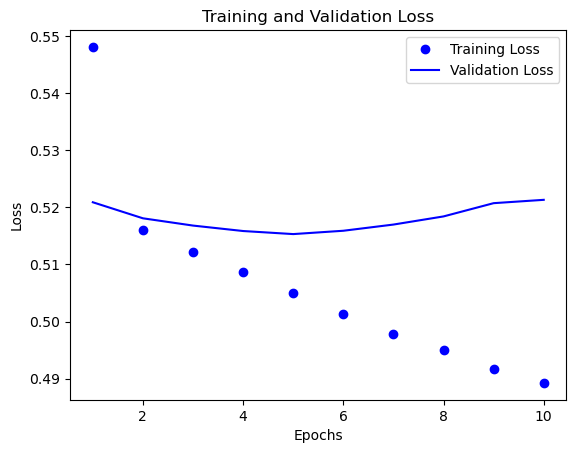

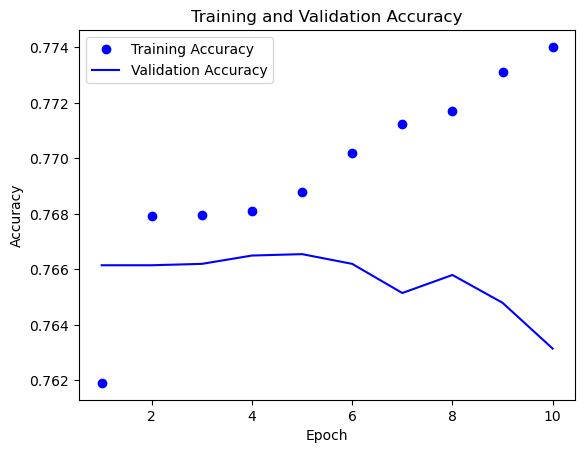

In [30]:
# BASELINE MODEL

plot_loss(history_base.history['loss'], history_base.history['val_loss'])
plot_accuracy(history_base.history['accuracy'], history_base.history['val_accuracy'])

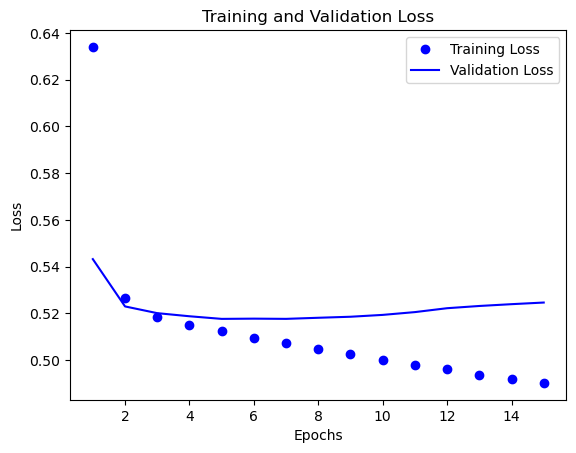

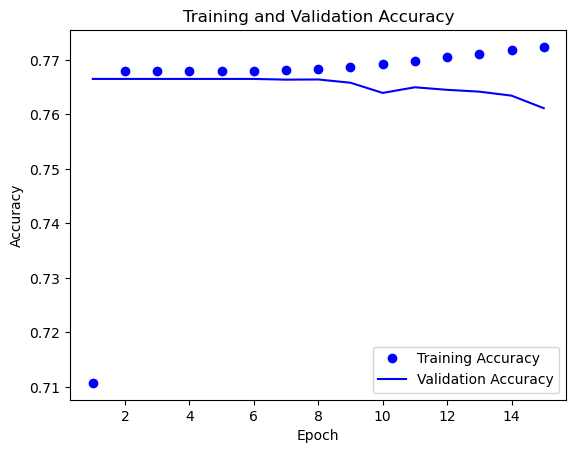

In [31]:
# OVERFITTING MODEL

plot_loss(history1.history['loss'], history1.history['val_loss'])
plot_accuracy(history1.history['accuracy'], history1.history['val_accuracy'])

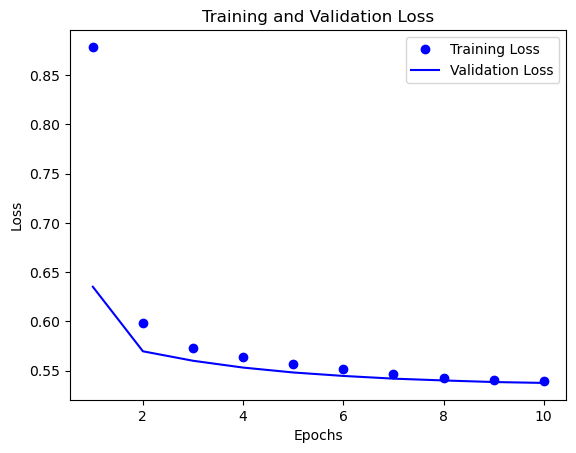

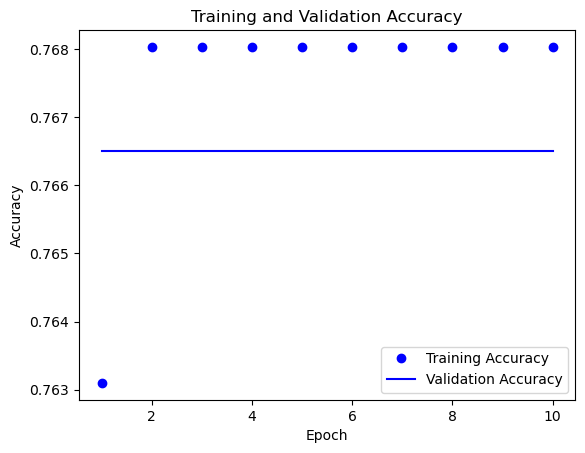

In [32]:
# WELL PERFORMING MODEL

plot_loss(history2.history['loss'], history2.history['val_loss'])
plot_accuracy(history2.history['accuracy'], history2.history['val_accuracy'])

### <center> Summary of AUC and loss results </center>

|  | Loss | Accuracy | AUC
| --- | --- | --- | --- |
| Baseline | 0.4908 | 77.34% | 0.7104 |
| Overfitting | 0.4973 | 77.02% | 0.6971 |
| Well performing | 0.5364 | 76.76% | 0.6174 |

The well performing model achieved the lowest AUC and loss compared to the baseline and overfitting model. While it produced the best graphs, the greater loss indicates that the margin of error on true values vs predicted values are larger. However, all the models still achieve statistical power.

It is important to note that while the well performing model achieved the lowest accuracy, we can see from the graph that the network converges unlike the other two graphs. This is indicative that the model performs well and may achieve higher accuracy on unseen test sets than the other two models.

<a id='conclusion'></a>
# Evaluation of Results

In conclusion, we were successful in training a model that produces a reasonable AUC and statistical power. Since an external dataset was used, it was harder to decide the categorical features to use in the model, as compared to using TensorFlow datasets which already has the data preparation portion handled. 

It was not possible to perform training using the entire dataset as there are 23 million records and would take too long to train due to limited computational resources. We also observe that our overfitting model achieved the highest AUC, as it starts to focus on the noise in the data. 

The model overfits very easily so it was harder to tune the parameters to create the well performing model, even then, the loss increased in the well performing model.

To improve on the model, we could try to implement an automated hyperarameter optimization model.

# Whats Next?

In the next iteration, we will be working on creating a model using the **Keras Functional API**, which is part of the advanced modelling technique found in Chapter 7 of 'Deep Learning with Python' by François Chollet.